In [11]:
import gensim
import sys
sys.path.insert(0, '../..')
from RETF.reddit_scraper.scrape import SubScraper
from RETF.portfolio.get_stats import Post
from RETF.portfolio.match_tickers import SymbolFinder
from RETF.portfolio.index import make_ticker_list

In [275]:
start_date = '2016-01-01'
end_date = '2016-10-30'
subreddit = 'stocks'

sf = SymbolFinder(make_ticker_list(['../../data/nyse.csv', '../../data/nasdaq.csv']))


def format_training_data(submission):
    p = Post(submission)
    # create text the same way it will be created in prod
    p.create_text() 
    # return filtered tokens
    return sf.clean_tokens(sf.tokenize(p.text))

scraper = SubScraper("../../RETF/credentials.txt")
submissions=scraper.get_submissions_between(subreddit, start_date, end_date)
sentences = [format_labeling_data(x) for x in submissions]

In [276]:
model = gensim.models.Word2Vec(sentences, min_count=5, size=10, window=6)
model.train(sentences, total_examples=len(sentences), epochs=50)

16367515

In [277]:
model.most_similar('AMD')

[('NVAX', 0.9162549376487732),
 ('NVDA', 0.8792522549629211),
 ('GILD', 0.8753766417503357),
 ('train', 0.8670171499252319),
 ('moment', 0.8434610962867737),
 ('SUNE', 0.8340556025505066),
 ('Thoughts', 0.8337333798408508),
 ('buying', 0.8325079083442688),
 ('Got', 0.831515371799469),
 ('MGT', 0.8232609033584595)]

In [278]:
model.most_similar('AAPL')

[('DWTI', 0.9573836326599121),
 ('SCTY', 0.9258369207382202),
 ('AH', 0.9231435060501099),
 ('SWHC', 0.9133439064025879),
 ('TWTR', 0.9041246175765991),
 ('OIL', 0.8911184072494507),
 ('Open', 0.8862718343734741),
 ('SLV', 0.882605791091919),
 ('TASR', 0.8763343095779419),
 ('GLD', 0.8743561506271362)]

In [214]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

mod = DBSCAN(eps=0.1, min_samples=6, n_jobs=-1, leaf_size=5, metric='cosine', algorithm='brute').fit(model.wv.syn0)
word_centroid_list = list(zip(model.wv.index2word, mod.labels_))

d = {}
for x, y in word_centroid_list:
    d.setdefault(y, []).append(x)

for i, x in sorted(d.items()):
    print(i, x[:5])

-1 ['the', 'to', 'and', 'of', 'in']
0 ['', 'a', 'I', 'this', 'it']
1 ['is', 'are', 'was', 'were', 'Is']
2 ['will', 'can', 'would', 'dont', 'should']
3 ['earnings', 'ER', 'late', 'earning', 'runup']
4 ['what', 'how', 'why', 'where', 'whatever']
5 ['buy', 'short', 'trade', 'sell', 'put']
6 ['price', 'high', 'low', 'higher', 'below']
7 ['YOLO', 'balls', 'Yolo', 'yachts', 'tendies']
8 ['VIX', 'futures', 'IV', 'bull', 'covering']
9 ['found', 'heard', 'mentioned', 'learned', 'worked']
10 ['ETFs', 'etfs', 'hedging', 'medium', 'LEAPS']
11 ['doing', 'done', 'wondering', 'interested', 'missing']
12 ['two', 'past', 'three', 'several', 'five']
13 ['k', 'couple', 'half', 'dollars', 'grand']
14 ['keeps', 'turns', 'crashes', 'finish', 'blows']
15 ['anyone', 'lucky', 'terrible', 'scared', 'greedy']
16 ['thinking', 'talking', 'Disclaimer', 'aware', 'overvalued']
17 ['amounts', 'tied', 'rent']
18 ['announcement', 'PDUFA', 'announcements', 'session', 'Christmas']
19 ['c', 'rolling', 'bidask', 'executed',

In [281]:
w1 = 'AMD'
w2 = 'NVDA'

print("the average of {0} and {1} is closest to:".format(w1, w2))
new = (model.wv.word_vec(w1) + model.wv.word_vec(w2))
model.similar_by_vector(new, topn=10, restrict_vocab=None)


the average of AMD and NVDA is closest to:


[('AMD', 0.9734013080596924),
 ('NVDA', 0.9650017619132996),
 ('NVAX', 0.9372652173042297),
 ('Thoughts', 0.9108309745788574),
 ('GILD', 0.9035331010818481),
 ('SUNE', 0.8633071780204773),
 ('train', 0.8533597588539124),
 ('MGT', 0.8516601920127869),
 ('SPHS', 0.844473123550415),
 ('NTDOY', 0.8397566080093384)]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(model.wv.syn0)

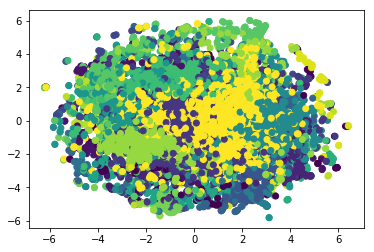

In [118]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=idx)
plt.show()

In [114]:
X_tsne.shape

(9376, 2)

In [119]:
idx

array([ 1, 15, 15, ...,  3, 16,  3], dtype=int32)